# Custom codes for Han et al. (2025)

This jupyter notebook generates all of the display items in Han et al. (2025). _Correspondence to Du et al._

## import libraries

In [2]:
import os
import re
import pandas as pd 
import numpy as np 
import sciris as sc 
import scipy.stats as st 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from zipfile import ZipFile

## parameters

In [3]:
# models 
vl_to_inf_models = ["hill", "negexp", "logit"] 

## functions

In [4]:
class analyze():
    def __init__(self, zf, fpath): 
        output = self.read_zip_output(zf, fpath) 
        
        # population 
        self.N = output.demography.sum() 
        self.demography = output.demography
        A = self.demography.shape[0]
        
        # get incidence 
        n_period = output.infected.shape[0] 
        self.incidence = np.zeros((n_period, 3), dtype=np.int32) # (n_period x (wt, emergent mt, transmitted mt))
        self.incidence[:,0] = output.infected.reshape((n_period, -1)).sum(axis=-1) # wild-type (drug sensitive) 
        for i in range(2): 
            # 0 = treatment-emergent mt incidence, 1 = transmitted mt incidence 
            self.incidence[:,i+1] = output.primary_mut_infected_n[i].reshape((366, -1)).sum(axis=-1)
        
        # get hospitalized (n_period x treatment group (untreated, BXM, OSL) x age categories) 
        self.daily_hospitalized = output.hospitalized
        
        # get deaths (n_period x age categories) 
        self.daily_deaths = output.deaths
        
        # testing 
        self.daily_tested = np.zeros((n_period, 2), dtype=np.int32) # (n_period x (wt, transmitted mt))
        self.daily_tested[:,0] = output.infected[:,1].reshape((n_period,-1)).sum(axis=-1)
        self.daily_tested[:,1] = output.primary_mut_infected_n[1][:,1].reshape((n_period,-1)).sum(axis=-1)
        
        # treatment 
        # (n_period x (TAT, contact traced) x (wt, transmitted mt) x (BXM, OSL) x (age categories))
        self.daily_treated = np.zeros((n_period, 2, 2, 2, A), dtype=np.int32) 
        # TAT x wt x BXM
        self.daily_treated[:,0,0,0] = output.treatment[:,0,0,1]
        # CT x wt x BXM 
        self.daily_treated[:,1,0,0] = output.treatment[:,1,0,1]
        # TAT x wt x OSL 
        self.daily_treated[:,0,0,1] = output.treatment[:,0,1,1]
        # CT x wt x OSL 
        self.daily_treated[:,1,0,1] = output.treatment[:,0,1,1]
        # TAT x mt x BXM
        self.daily_treated[:,0,1,0] = output.treatment[:,0,0,2]
        # CT x mt x BXM 
        self.daily_treated[:,1,1,0] = output.treatment[:,1,0,2]
        # TAT x mt x OSL 
        self.daily_treated[:,0,1,1] = output.treatment[:,0,1,2]
        # CT x mt x OSL 
        self.daily_treated[:,1,1,1] = output.treatment[:,0,1,2]
        
    def compute_weekly_counts(self, daily_counts):
        # compute weekly counts 
        weekly_counts = np.zeros(int(daily_counts.size/7))
        for w, d in enumerate(np.arange(8, daily_counts.size, 7)):
            weekly_counts[w] = daily_counts[d-7:d].sum()
        return weekly_counts

    def read_zip_output(self, zf, fpath):
        core_files = ['demography.npz', 'infected.npz', 'primary_mut_infected_n.npz', 'treatment.npz', 'pos_cases.npz', 'hospitalized.npz', 'deaths.npz']
        output = sc.objdict()
        for f in core_files: 
            flabel = f.replace(".npz", "")
            with zf.open(fpath + f) as z: 
                output[flabel] = np.load(z)['arr']
        return output

def extract_results_from_zipfile(fpath, model=None): 
    """
    parse through zip file folders to extract results 
    """
    df = []
    
    with ZipFile(fpath, 'r') as zf:
        for foldername in zf.namelist():
            # find results folder 
            try: 
                zf.open(foldername + "deaths.npz")
            except: 
                continue 
            # read results folder 
            output_obj = analyze(zf, foldername)
            # get country and pandemic 
            country, pandemic = "USA", "us_seasonal_1718"
            region = "NA"
            
            try: 
                model = re.search("(" + "|".join(vl_to_inf_models) + ")", foldername).group()
            except: 
                pass 
            
            row_dict = {"model":model, "region":region, "country":country, "pandemic":pandemic}
            
            # get test sensitivity 
            try: 
                TS = int(re.search("TS([0-9]+)", foldername).group(1))
                row_dict['baseline'] = 0
            except: 
                row_dict['baseline'] = 1

            if row_dict["baseline"] == 0: 
                # extract non-baseline parameters 
                row_dict['TS'] = TS
                row_dict["TW"] = int(re.search("TW([0-9]+)", foldername).group(1))
                # get average delay to TAT since symptom onset and treatment 
                tat_delay = int(re.search("_(1|2|5)D_", foldername).group(1))
                if tat_delay == 2: 
                    row_dict["tat_delay"] = 3
                elif tat_delay == 5: 
                    row_dict["tat_delay"] = 7 
                else: 
                    row_dict["tat_delay"] = 1
                    
                treatment = re.search("(BXM[0-9][0-9]-[0-9][0-9]|BXM|OSL)", foldername).group()
                # treatment 
                row_dict["treatment"] = treatment
                
            # read output 
            row_dict["pop_N"] = output_obj.N
            # get number of incidence and deaths 
            row_dict["n_wt"] = output_obj.incidence[:,0].sum()
            row_dict["n_emerge_mt"] = output_obj.incidence[:,1].sum()
            row_dict["n_trans_mt"] = output_obj.incidence[:,2].sum()
            row_dict["n_deaths"] = output_obj.daily_deaths.sum()
            # get minimum testing needed 
            row_dict['n_test'] = output_obj.daily_tested.sum()
            # get number of treatments needed 
            row_dict['n_treatment'] = output_obj.daily_treated.sum()
            # get weekly incidence 
            row_dict['weekly_incidence'] = output_obj.compute_weekly_counts(output_obj.incidence[:,0])

            df.append(row_dict)
            
    df = pd.DataFrame.from_dict(df)
    return df 

## Read simulation outputs

In [7]:
us_seasonal_df = []
for root, dirs, files in os.walk("../simulations/us_seasonal_1718/"): 
    for file in files: 
        if re.search(".zip", file): 
            fpath = root + "/" + file
            df = extract_results_from_zipfile(fpath)
            us_seasonal_df.append(df)

us_seasonal_df = pd.concat(us_seasonal_df, ignore_index=True)
baseline_df = us_seasonal_df[us_seasonal_df["baseline"]>0]
analysis_df = us_seasonal_df[us_seasonal_df["baseline"]==0]

# compute infections averted 
for model in baseline_df['model'].unique(): 
    index = analysis_df[analysis_df['model']==model].copy().index
    baseline_n_wt = baseline_df[baseline_df['model']==model]['n_wt'].iloc[0]
    analysis_df.loc[index, 'n_inf_averted'] = baseline_n_wt - analysis_df.loc[index, "n_wt"]
    analysis_df.loc[index, 'f_inf_averted'] = 100 * (analysis_df.loc[index, 'n_inf_averted']/baseline_n_wt)
analysis_df.head()

/var/folders/xf/bddbfrwn1rg8t997nj27q93h0000gn/T/ipykernel_52699/208559491.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[index, 'n_inf_averted'] = baseline_n_wt - analysis_df.loc[index, "n_wt"]
/var/folders/xf/bddbfrwn1rg8t997nj27q93h0000gn/T/ipykernel_52699/208559491.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[index, 'f_inf_averted'] = 100 * (analysis_df.loc[index, 'n_inf_averted']/baseline_n_wt)


,model,region,country,pandemic,baseline,TS,TW,tat_delay,treatment,pop_N,n_wt,n_emerge_mt,n_trans_mt,n_deaths,n_test,n_treatment,weekly_incidence,n_inf_averted,f_inf_averted
0,logit,NA,USA,us_seasonal_1718,0,100.0,50.0,1.0,BXM,336997617,26045942,0,0,3387,9537619,9522159,"[44003.0, 48006.0, 54369.0, 61237.0, 69740.0, ...",49107042.0,65.342771
1,logit,NA,USA,us_seasonal_1718,0,70.0,40.0,1.0,BXM,336997617,49088314,0,0,7945,14814661,10351840,"[50448.0, 60943.0, 77296.0, 97482.0, 124260.0,...",26064670.0,34.682149
2,logit,NA,USA,us_seasonal_1718,0,70.0,40.0,7.0,BXM,336997617,65321196,0,0,11713,18998530,8165805,"[56160.0, 74082.0, 102990.0, 142614.0, 199288....",9831788.0,13.082365
3,logit,NA,USA,us_seasonal_1718,0,70.0,50.0,3.0,BXM,336997617,51664792,0,0,8220,18513058,12111442,"[51494.0, 63012.0, 81133.0, 103862.0, 134344.0...",23488192.0,31.253838
4,logit,NA,USA,us_seasonal_1718,0,70.0,10.0,3.0,BXM,336997617,70347407,0,0,13504,5724506,3687239,"[57853.0, 78590.0, 112387.0, 160270.0, 230524....",4805577.0,6.394393


## Get US ILI data

In [8]:
season = "2017-2018"
us_ili_data = pd.read_csv("../data/US_%s_ILIdata/ILINet.csv"%(season), skiprows=1).set_index(["YEAR", "WEEK"]).sort_index()
who_pp_data = pd.read_csv("../data/US_%s_ILIdata/WHO_NREVSS_Clinical_Labs.csv"%(season), skiprows=1).set_index(["YEAR", "WEEK"]).sort_index()
us_time_weeks = list(who_pp_data.index)
us_incidence_data = us_ili_data.loc[us_time_weeks, '% WEIGHTED ILI'].to_numpy() * who_pp_data.loc[us_time_weeks, 'PERCENT POSITIVE'].to_numpy() * 100
us_incidence_data

array([  278.94236262,   273.0509145 ,   293.53180302,   392.25090009,
         630.52904097,   793.96214184,  1095.30193084,  1617.3280876 ,
        1669.47245424,  2777.445144  ,  5170.1637339 , 10747.008572  ,
       14521.9347104 , 14649.5514579 , 15918.200943  , 17547.63423   ,
       19646.0150702 , 20375.3853193 , 19936.0449944 , 16873.6163832 ,
       11202.3843855 ,  6789.6842558 ,  5027.822706  ,  4345.1415497 ,
        3835.586752  ,  3643.3358775 ,  2633.4589296 ,  2004.8829724 ,
        1518.81299304,  1231.74504992,   958.3682211 ,   569.34266289,
         376.45719824,   298.61273823,   174.54969156,   155.88021026,
         116.32928276,    91.30069668,    97.73003442,    77.7383811 ,
          66.50613588,    71.9114044 ,    63.73877772,    61.13096875,
          67.62918798,    54.16569211,   110.33990838,   129.9785881 ,
         192.41210246,   194.4684878 ,   204.35151753,   187.17315067])

## Validation against US ILI regardless of the infectiousness models

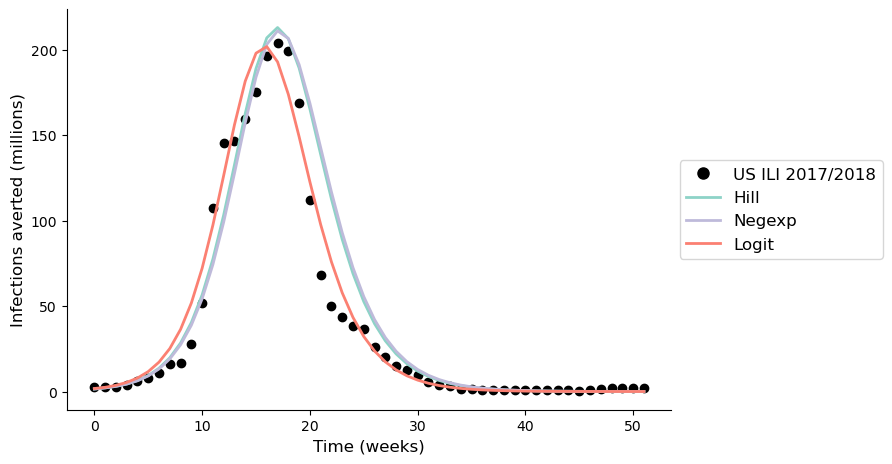

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7.8, 10.4*0.5))
X = np.arange(us_incidence_data.size)
for model, col in zip(vl_to_inf_models, ['#8dd3c7','#bebada','#fb8072']): 
    fdf = baseline_df[baseline_df["model"]==model]
    weekly_incidence = 1e4 * fdf['weekly_incidence'].to_numpy()[0]/fdf['pop_N'].iloc[0]
    ax.plot(X, weekly_incidence, lw=2., c=col, zorder=100)
ax.scatter(np.arange(us_incidence_data.size), us_incidence_data/100, zorder=0, c='k')
for axis in ['top', 'right']: 
    ax.spines[axis].set_visible(False)
ax.set_ylabel("Infections averted (millions)", fontsize=12)
ax.set_xlabel("Time (weeks)", fontsize=12)
ax.tick_params(labelsize=10, axis='both')

legend_handles = []
legend_handles.append(Line2D([0], [0], marker='o', color='k', 
                                 label="US ILI 2017/2018", 
                                  markerfacecolor='k', 
                                 lw=0., markersize=8.))
for model, col in zip(vl_to_inf_models, ['#8dd3c7','#bebada','#fb8072']):  
    legend_handles.append(Line2D([0], [0], marker='o', color=col, 
                                 label=model.capitalize(), markerfacecolor=col, 
                                 lw=2., markersize=0.))
ax.legend(handles=legend_handles, ncols=1, loc="center left", bbox_to_anchor=(1., 0.5), fontsize=12)
plt.savefig("../manuscript/lancetID_fig_s04.png", bbox_inches='tight', dpi=600)
plt.show()

## Figure 1: 

82457872 58533331
Infections averted
10 [8.001096, 5.571314, 4.339978, 2.388638]
20 [15.97873, 11.071991, 8.601273, 4.746552]
30 [23.924541, 16.492447, 12.779619, 7.072854]
40 [31.88207, 21.829087, 16.871919, 9.366848]
50 [40.023821, 27.088111, 20.877394, 11.628321]
Tests required
10 [60.90715999999999, 62.89526, 63.56924, 64.84952]
20 [105.90135999999998, 113.71931999999998, 116.45688, 121.41139]
30 [136.14228, 153.43694, 159.65525, 170.42649]
40 [152.61351, 182.98262999999997, 194.1, 212.5823]
50 [155.65008999999998, 203.21748, 220.66496, 248.51642999999999]


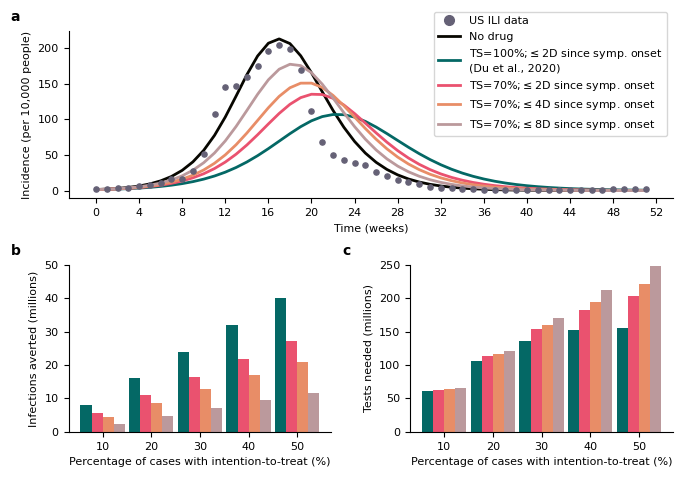

In [10]:
def ax_cosmetics(ax): 
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.tick_params(axis='both', labelsize=8)
    
model = 'hill' 

fig = plt.figure(figsize=(7.8, 10.4*0.5))
gs = GridSpec(nrows=2, ncols=1, hspace=0.4)

## Fig. 1a) incidence curves 
ax = fig.add_subplot(gs[0])
X = np.arange(us_incidence_data.size)
ax.scatter(X, us_incidence_data/100, s=14, c="#656176", zorder=100)

baseline = baseline_df[baseline_df["model"]==model]
ax.plot(X, 1e4 * baseline["weekly_incidence"].iloc[0]/baseline_df['pop_N'].iloc[0], c='#070600', lw=2.)

du_et_al = analysis_df[(analysis_df["TW"]==30)&(analysis_df["TS"]==100)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
ax.plot(X, 1e4 * du_et_al["weekly_incidence"].iloc[0]/baseline_df['pop_N'].iloc[0], c='#046865', lw=2.)

real_ts = analysis_df[(analysis_df["TW"]==30)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
ax.plot(X, 1e4 * real_ts["weekly_incidence"].iloc[0]/baseline_df['pop_N'].iloc[0], c='#EA526F', lw=2.)

real_ts_3d = analysis_df[(analysis_df["TW"]==30)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==3)&(analysis_df["model"]==model)]
ax.plot(X, 1e4 * real_ts_3d["weekly_incidence"].iloc[0]/baseline_df['pop_N'].iloc[0], c='#E88D67', lw=2.)

real_ts_7d = analysis_df[(analysis_df["TW"]==30)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==7)&(analysis_df["model"]==model)]
ax.plot(X, 1e4 * real_ts_7d["weekly_incidence"].iloc[0]/baseline_df['pop_N'].iloc[0], c='#BB999C', lw=2.)

print (baseline['n_wt'].iloc[0], du_et_al['n_wt'].iloc[0])
#print (baseline['n_deaths'].iloc[0] - du_et_al['n_deaths'].iloc[0])
ax.set_ylabel("Incidence (per 10,000 people)", fontsize=8)
ax.set_xticks(np.arange(0, 53, 4))
ax.set_xlabel("Time (weeks)", fontsize=8)
ax_cosmetics(ax)
ax.text(x=0.05, y=.9, s=r"$\bf{a}$", fontsize=10, transform=fig.transFigure)

legend_handles = []
cmap = ["#656176", "#070600", "#046865", "#EA526F", "#E88D67", "#BB999C"]
for i, (col, label) in enumerate(zip(cmap, ["US ILI data", "No drug", 
                                            "TS=100%;" +  r"$\leq$" + "2D since symp. onset" + "\n(Du et al., 2020)",
                                            "TS=70%;" +  r"$\leq$" + "2D since symp. onset",
                                            "TS=70%;" +  r"$\leq$" + "4D since symp. onset",
                                            "TS=70%;" +  r"$\leq$" + "8D since symp. onset",])): 
    legend_handles.append(Line2D([0], [0], marker='o', color=col, 
                                 label=label, markerfacecolor=col, 
                                 lw=0. if i < 1 else 2., markersize=7 if i < 1 else 0.))
ax.legend(handles=legend_handles, ncols=1, loc="upper right", bbox_to_anchor=(1.0, 1.15), fontsize=8)

## row 2 ## 
gs1 = gs[1].subgridspec(nrows=1, ncols=2, wspace=0.3)

## Fig. 1b) Infections averted 
print ("Infections averted")
ax = fig.add_subplot(gs1[0]) 
ax_cosmetics(ax)

X = [10, 20, 30, 40, 50]
Y = []
for TW in X: 
    TW_f_inf_averted = []
    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==100)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_inf_averted'].iloc[0]/1e6)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_inf_averted'].iloc[0]/1e6)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==3)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_inf_averted'].iloc[0]/1e6)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==7)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_inf_averted'].iloc[0]/1e6)
    Y.append(TW_f_inf_averted)

    print (TW, TW_f_inf_averted)

bar_width = 0.25
offset = 0.1
multiplier = 0
xticks = []
for x, yvals in enumerate(Y): 
    xx = x + ((np.arange(len(yvals)) - 1.5) * bar_width) + offset*multiplier
    ax.bar(xx, yvals, width=bar_width, color=["#046865", "#EA526F", "#E88D67", "#BB999C"])
    multiplier += 1
    xticks.append(xx[0] + (xx[-1]-xx[0])/2)
ax.set_xticks(xticks)
ax.set_xticklabels(X)
ax.set_ylim(0., 50.)
ax.set_ylabel("Infections averted (millions)", fontsize=8)
ax.set_xlabel("Percentage of cases with intention-to-treat (%)", fontsize=8)
ax.text(x=0.05, y=.45, s=r"$\bf{b}$", fontsize=10, transform=fig.transFigure)

## Fig. 1c) Tests required 
print ("Tests required")
ax = fig.add_subplot(gs1[1]) 
ax_cosmetics(ax)

X = [10, 20, 30, 40, 50]
Y = []
for TW in X: 
    TW_f_inf_averted = []
    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==100)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_test'].iloc[0]/1e6/0.1)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==1)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_test'].iloc[0]/1e6/0.1)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==3)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_test'].iloc[0]/1e6/0.1)

    plot_df = analysis_df[(analysis_df["TW"]==TW)&(analysis_df["TS"]==70)&(analysis_df["tat_delay"]==7)&(analysis_df["model"]==model)]
    TW_f_inf_averted.append(plot_df['n_test'].iloc[0]/1e6/0.1)
    Y.append(TW_f_inf_averted)

    print (TW, TW_f_inf_averted)

bar_width = 0.25
offset = 0.1
multiplier = 0
xticks = []
for x, yvals in enumerate(Y): 
    xx = x + ((np.arange(len(yvals)) - 1.5) * bar_width) + offset*multiplier
    ax.bar(xx, yvals, width=bar_width, color=["#046865", "#EA526F", "#E88D67", "#BB999C"])
    multiplier += 1
    xticks.append(xx[0] + (xx[-1]-xx[0])/2)
ax.set_xticks(xticks)
ax.set_xticklabels(X)
ax.set_ylim(0., 250.)
ax.set_ylabel("Tests needed (millions)", fontsize=8)
ax.set_xlabel("Percentage of cases with intention-to-treat (%)", fontsize=8)
ax.text(x=0.475, y=.45, s=r"$\bf{c}$", fontsize=10, transform=fig.transFigure)

plt.savefig("../manuscript/natcomms_correspondence/natcomms_figure_01.png", dpi=600)
plt.show()